In [9]:
os.getcwd()

'D:\\Projects\\DL\\MonumentDetection\\DL'

In [176]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path
import math
import keras_cv
import matplotlib.pyplot as plt
import keras_cv.visualization as visualization
import cv2
import keras
from keras_cv import models, losses, callbacks
import keras_cv.losses as losses
from keras_cv.models import YOLOV8Detector
import matplotlib.patches as patches
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

## Visualization

In [177]:
IMAGE_SIZE = (640, 640)  # Input size for YOLOv8
BATCH_SIZE = 3  # Number of samples per batch
NUM_CLASSES = 1  # Example number of classes, adjust as needed
BOUNDING_BOX_FORMAT = "xywh"  # YOLO bounding box format
PAD_TO_ASPECT_RATIO = True  # To maintain aspect ratio when resizing

In [178]:
# Paths to the datasets
TRAIN_IMAGES_DIR = Path("dataset/train/images/")
TRAIN_LABELS_DIR = Path("dataset/train/labels/")

VAL_IMAGES_DIR = Path("dataset/val/images/")
VAL_LABELS_DIR = Path("dataset/val/labels/")

In [179]:
# Assuming TRAIN_IMAGES_DIR is a directory containing image file paths
for filename in os.listdir(TRAIN_IMAGES_DIR):
    image_path = TRAIN_IMAGES_DIR / filename  # Construct the full image path
    if not image_path.exists():
        print(f"File does not exist: {image_path}")
        continue

    image = cv2.imread(str(image_path))  # Convert to string if necessary for cv2.imread
    
    if image is None:
        print(f"Failed to read image: {image_path}")
    else:
        print(image.shape)


(408, 612, 3)
(338, 509, 3)
(960, 545, 3)
(612, 408, 3)
(408, 612, 3)
(413, 612, 3)
(612, 408, 3)
(612, 408, 3)
(406, 612, 3)
(612, 343, 3)
(360, 640, 3)
(612, 408, 3)
(407, 612, 3)
(667, 1000, 3)
(612, 408, 3)
(408, 612, 3)
(612, 476, 3)
(612, 408, 3)
(612, 392, 3)
(408, 612, 3)
(612, 408, 3)
(400, 612, 3)
(360, 540, 3)
(330, 660, 3)
(612, 416, 3)
(408, 612, 3)
(612, 392, 3)
(408, 612, 3)
(338, 507, 3)
(612, 398, 3)
(612, 408, 3)
(612, 408, 3)
(612, 408, 3)
(408, 612, 3)
(612, 408, 3)
(612, 408, 3)
(408, 612, 3)
(612, 408, 3)
(408, 612, 3)
(720, 960, 3)
(339, 509, 3)
(612, 413, 3)
(360, 640, 3)
(408, 612, 3)
(360, 458, 3)
(408, 612, 3)
(490, 612, 3)
(612, 406, 3)
(612, 408, 3)
(459, 612, 3)
(338, 509, 3)
(408, 612, 3)
(408, 612, 3)
(640, 516, 3)
(400, 612, 3)
(339, 509, 3)
(408, 612, 3)
(428, 612, 3)
(612, 408, 3)
(612, 408, 3)
(612, 392, 3)
(612, 591, 3)
(408, 612, 3)
(612, 408, 3)
(612, 408, 3)
(408, 612, 3)
(438, 612, 3)
(667, 1000, 3)
(612, 408, 3)
(408, 612, 3)
(612, 406, 3)
(360

In [180]:
# Function to load YOLO annotations
def load_yolo_annotations(label_path, image_size):
    annotations = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ")
            if len(parts) != 5:
                continue  # Skip lines that don't match expected format

            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Convert normalized "xywh" to pixel-based "xyxy" format
            x_min = (x_center - width / 2) * image_size[0]
            y_min = (y_center - height / 2) * image_size[1]
            x_max = (x_center + width / 2) * image_size[0]
            y_max = (y_center + height / 2) * image_size[1]

            annotations.append([x_min, y_min, x_max, y_max, class_id])

    return np.array(annotations, dtype=np.float32)

In [181]:
# Function to load image and corresponding annotations
def load_sample(image_path, labels_dir):
    image_path_str = tf.keras.backend.get_value(image_path).decode("utf-8")  # Convert tensor to string
    image = Image.open(image_path_str).resize(IMAGE_SIZE)  # Resize to 640x640
    image = np.array(image) / 255.0  # Normalize
    
    # Construct the label path and validate its existence
    image_stem = Path(image_path_str).stem
    label_path = os.path.join(labels_dir, image_stem + ".txt")

    if not os.path.isfile(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    # Load YOLO annotations
    annotations = load_yolo_annotations(label_path, IMAGE_SIZE)  # Load annotations
    return image, annotations

In [390]:
# Function to resize image for inference
def inference_resizing(image, annotations):
    print(f"Image shape: {image.shape}, Annotations: {annotations}")
    resized_image = tf.image.resize(image, [640, 640])
    return resized_image, annotations

In [391]:
# Function to count elements in a dataset
def count_elements(dataset):
    return dataset.cardinality().numpy()

# Check if the dataset is empty
def is_dataset_empty(dataset):
    return count_elements(dataset) <= 0

In [392]:
# Function to separate class IDs from bounding box coordinates
def extract_bounding_box_info(bounding_boxes_raw):
    # Check if the last dimension has five elements
    if bounding_boxes_raw.shape[-1] == 5:
        # Extract the class ID (last element) and bounding box coordinates
        class_ids = bounding_boxes_raw[..., -1]  # The last element is the class ID
        bounding_boxes = bounding_boxes_raw[..., :-1]  # The rest is the bounding box coordinates
    else:
        raise ValueError(f"Unexpected bounding box shape: {bounding_boxes_raw.shape}")
    return bounding_boxes, class_ids

In [393]:
# Function to normalize image data
def normalize_image_data(image):
    print(f"Original image shape: {image.shape}")  # Debug print
    # Convert TensorFlow tensor to NumPy array
    image = image.numpy()  # Explicit conversion
    # If data is in float format, scale to [0, 255]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
    print(f"Normalized image shape: {image.shape}")  # Debug print
    return image

In [394]:
# Function to convert from BGR to RGB if needed
def ensure_rgb_format(image):
    # If the image appears incorrect, try converting BGR to RGB
    if image.shape[-1] == 3:  # Assuming three channels (RGB or BGR)
        return image[..., ::-1]  # Reverse the color channels to convert BGR to RGB
    return image


In [395]:
def filter_empty_annotations(image, annotations):
    # Check if all annotation values are equal to -1
    is_empty = tf.reduce_all(tf.equal(annotations, -1), axis=-1)
    # Return True if any annotation is not empty, False otherwise
    return tf.math.logical_not(tf.reduce_all(is_empty))

In [396]:
def pad_annotations(image, annotations, max_annotations=5):
    print(f"Image shape: {image.shape}, Annotations: {annotations}")  # Debug print
    num_annotations = tf.shape(annotations)[0]
    annotations = tf.reshape(annotations, [num_annotations, 5])

    padding = [[0, max_annotations - num_annotations], [0, 0]]
    annotations = tf.pad(annotations, padding, constant_values=-1)

    boxes = annotations[:, :4]
    classes = tf.expand_dims(annotations[:, 4], axis=-1)
    
    return image, {'boxes': boxes, 'classes': classes}

In [397]:
def data_loader(images_dir, labels_dir, batch_size):
    image_paths = list(Path(images_dir).rglob("*.jpg")) + list(Path(images_dir).rglob("*.png"))

    if len(image_paths) == 0:
        raise ValueError(f"No images found in {images_dir}. Check your dataset path.")

    dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])

    def load_sample_with_shape(image_path):
        image, annotations = tf.py_function(
            lambda y: load_sample(y, labels_dir),
            [image_path],
            [tf.float32, tf.float32]
        )
        image.set_shape(IMAGE_SIZE + (3,))
        annotations.set_shape([None, 5])
        return image, annotations

    dataset = dataset.map(load_sample_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    def resize_with_shape(image, annotations):
        image, annotations = tf.py_function(
            func=lambda img, ann: inference_resizing(img, ann),
            inp=[image, annotations],
            Tout=[tf.float32, tf.float32]
        )
        image.set_shape([640, 640, 3])
        annotations.set_shape([None, 5])
        return image, annotations

    dataset = dataset.map(resize_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    def normalize_with_shape(image, annotations):
        image, annotations = tf.py_function(
            func=lambda img, ann: (normalize_image_data(img), ann),
            inp=[image, annotations],
            Tout=[tf.float32, tf.float32]
        )
        image.set_shape([640, 640, 3])
        annotations.set_shape([None, 5])
        return image, annotations

    dataset = dataset.map(normalize_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    def ensure_rgb_with_shape(image, annotations):
        image, annotations = tf.py_function(
            func=lambda img, ann: (ensure_rgb_format(img), ann),
            inp=[image, annotations],
            Tout=[tf.float32, tf.float32]
        )
        image.set_shape([640, 640, 3])
        annotations.set_shape([None, 5])
        return image, annotations

    dataset = dataset.map(ensure_rgb_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.filter(lambda image, annotations: tf.py_function(
        func=filter_empty_annotations,
        inp=[image, annotations],
        Tout=tf.bool)
    )

    dataset = dataset.map(lambda image, annotations: pad_annotations(image, annotations))

    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

    return dataset

Image shape: (640, 640, 3), Annotations: Tensor("args_1:0", shape=(None, 5), dtype=float32)
Image shape: (640, 640, 3), Annotations: Tensor("args_1:0", shape=(None, 5), dtype=float32)
Image shape: (640, 640, 3), Annotations: [[179.3936    3.87872 432.4848  864.9699    0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 22.63264 113.6096  226.32608 340.8288    0.     ]]
Original image shape: (640, 640, 3)
Original image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Image shape: (640, 640, 3), Annotations: [[ 21.96096   7.32    607.0592  404.7056    0.     ]]
Image shape: (640, 640, 3), Annotations: [[219.60768  89.41184 387.97375 581.96094   0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 24.66016   4.66624 573.064   325.33313   0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 78.43136   7.32    619.60767 413.0717    0.     ]]
Image shape: (640, 640, 3), Annotations: [[  6.27456   3.09952 638.9542  946.8282    0.     ]]
Ori

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Normalized image shape: (640, 640, 3)
Image shape: (640, 640, 3), Annotations: [[109.80416  41.82976 580.39233 386.928     0.     ]]
Normalized image shape: (640, 640, 3)
Original image shape: (640, 640, 3)
Original image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Original image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)


ValueError: not enough values to unpack (expected 5, got 1)

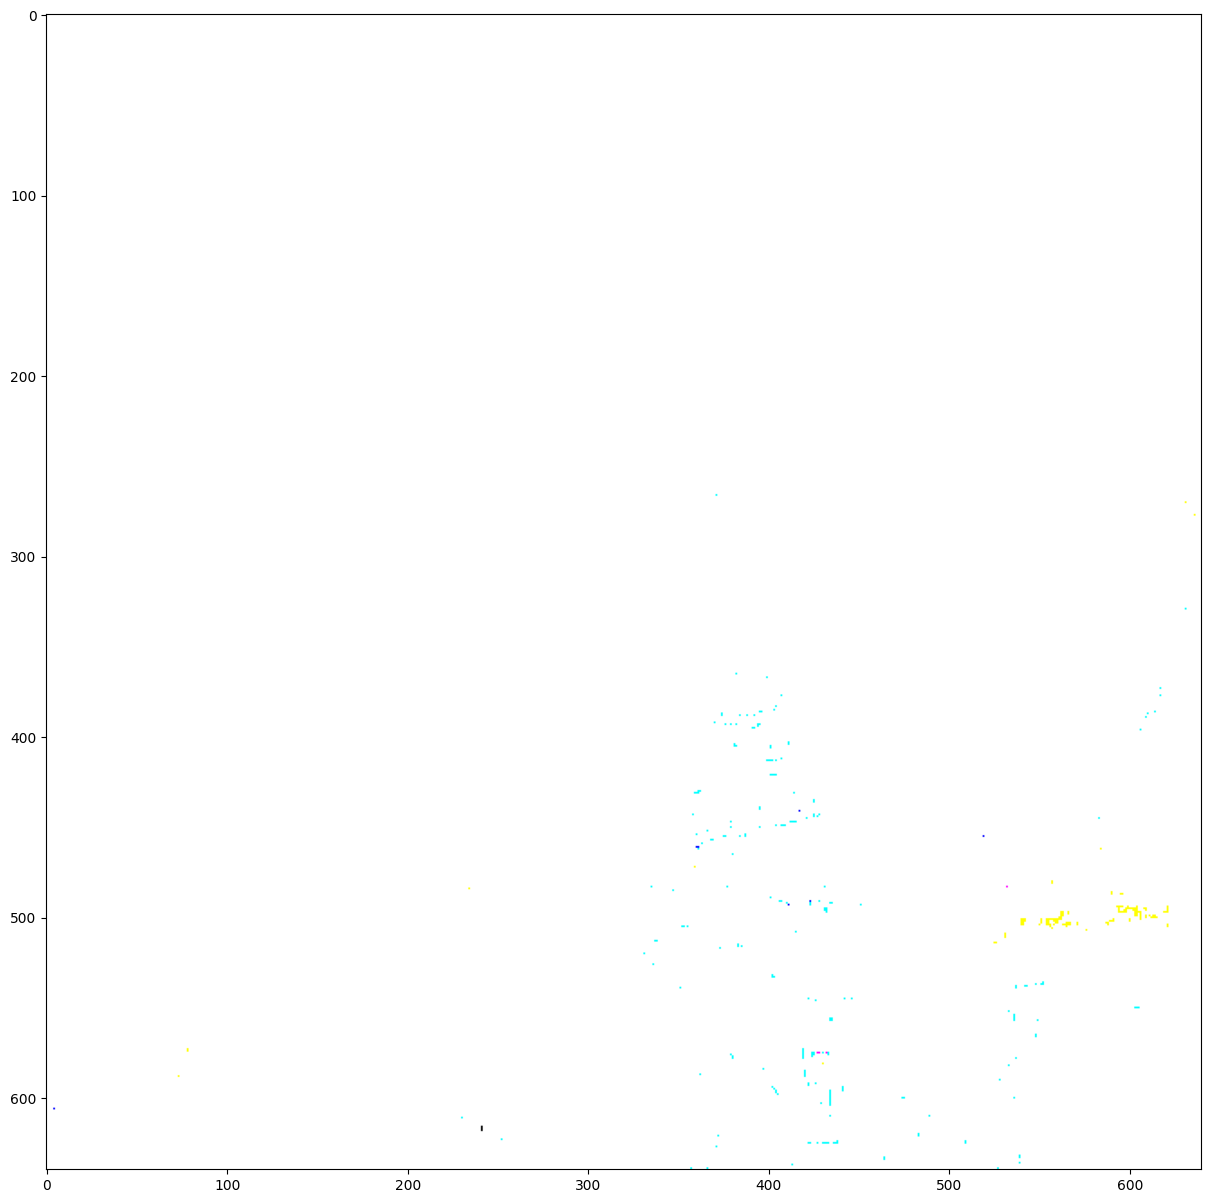

In [398]:
# Function to visualize the dataset
def visualize_dataset(dataset, value_range, default_rows, default_cols, bounding_box_format):
    # Get the first batch from the dataset
    batch = next(iter(dataset.take(1)))  # Get the first batch

    # Extract images and raw bounding boxes
    images, bounding_boxes_raw = batch

    # Adjust the number of rows and columns for visualization
    rows = default_rows
    cols = default_cols

    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.flatten() if rows * cols > 1 else [axs]

    for ax, image, bboxes in zip(axs, images, bounding_boxes_raw):
        ax.imshow(image, vmin=value_range[0], vmax=value_range[1])
        for bbox in bboxes:
            if tf.reduce_all(bbox != -1):  # Ensure bounding box is not just padding
                x_min, y_min, x_max, y_max, _ = bbox
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Create datasets for training, validation, and testing
train_dataset = data_loader(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, BATCH_SIZE)
val_dataset = data_loader(VAL_IMAGES_DIR, VAL_LABELS_DIR, BATCH_SIZE // 2)

# Visualize the dataset
visualize_dataset(train_dataset, value_range=(0, 1), default_rows=1, default_cols=1, bounding_box_format="xyxy")


In [399]:
# Create datasets for training, validation, and testing
train_dataset = data_loader(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, BATCH_SIZE)
val_dataset = data_loader(VAL_IMAGES_DIR, VAL_LABELS_DIR, BATCH_SIZE // 2)

Image shape: (640, 640, 3), Annotations: Tensor("args_1:0", shape=(None, 5), dtype=float32)
Image shape: (640, 640, 3), Annotations: Tensor("args_1:0", shape=(None, 5), dtype=float32)


Image shape: (640, 640, 3), Annotations: [[179.3936    3.87872 432.4848  864.9699    0.     ]]
Original image shape: (640, 640, 3)
Image shape: (640, 640, 3), Annotations: [[ 22.63264 113.6096  226.32608 340.8288    0.     ]]
Original image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Image shape: (640, 640, 3), Annotations: [[ 24.66016   4.66624 573.064   325.33313   0.     ]]
Image shape: (640, 640, 3), Annotations: [[  6.27456   3.09952 638.9542  946.8282    0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 21.96096   7.32    607.0592  404.7056    0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 95.68608  15.6864  487.84286 325.2288    0.     ]]
Original image shape: (640, 640, 3)
Image shape: (640, 640, 3), Annotations: [[ 78.43136   7.32    619.60767 413.0717    0.     ]]
Original image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Image shape: (640, 640, 3), Annotations: [[ 20.9152  130.83711 215.42528 324.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: not enough values to unpack (expected 5, got 1)

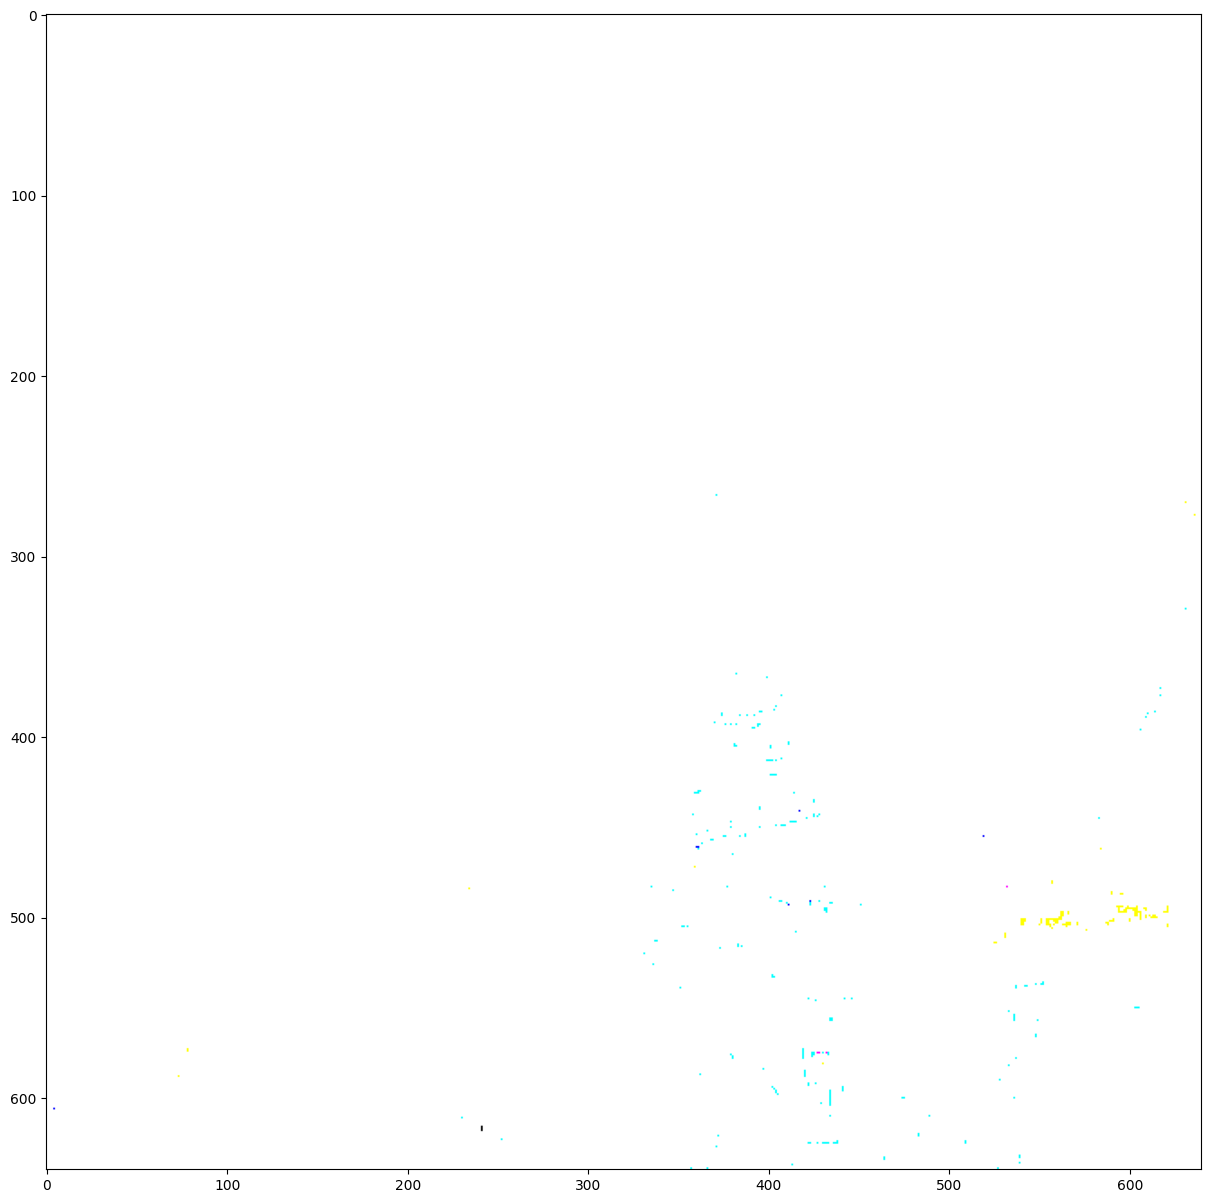

In [400]:
visualize_dataset(train_dataset, value_range=(0, 1), default_rows=1, default_cols=1, bounding_box_format="xywh")

In [ ]:
visualize_dataset(val_dataset, value_range=(0, 1), default_rows=1, default_cols=1, bounding_box_format="xywh")

## Model

In [401]:
for image, annotations in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Annotations:", annotations)


Image shape: (640, 640, 3), Annotations: [[179.3936    3.87872 432.4848  864.9699    0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 22.63264 113.6096  226.32608 340.8288    0.     ]]
Original image shape: (640, 640, 3)
Original image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Image shape: (640, 640, 3), Annotations: [[ 24.66016   4.66624 573.064   325.33313   0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 21.96096   7.32    607.0592  404.7056    0.     ]]
Image shape: (640, 640, 3), Annotations: [[219.60768  89.41184 387.97375 581.96094   0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 78.43136   7.32    619.60767 413.0717    0.     ]]
Image shape: (640, 640, 3), Annotations: [[ 95.68608  15.6864  487.84286 325.2288    0.     ]]
Original image shape: (640, 640, 3)
Original image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Original image shape: (640, 640, 3)
Normalized image shape: (640, 640, 3)
Ima

In [402]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [403]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

In [404]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

In [405]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_dataset.take(20), bounding_box_format="xywh"
)

In [406]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=1,
)

In [407]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

In [408]:
model.fit(
    train_dataset.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

ValueError: Exception encountered when calling Cond.call().

[1mDimension must be 4 but is 3 for '{{node yolov8_label_encoder_11_1/cond/transpose}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32](yolov8_label_encoder_11_1/cond/Reshape_2, yolov8_label_encoder_11_1/cond/transpose/perm)' with input shapes: [?,?,?,?], [3].[0m

Arguments received by Cond.call():
  • args=('tf.Tensor(shape=(), dtype=bool)', '<function YOLOV8LabelEncoder.call.<locals>.<lambda> at 0x0000016A9B5D1E40>', '<function YOLOV8LabelEncoder.call.<locals>.<lambda> at 0x0000016A9B5D1DA0>')
  • kwargs=<class 'inspect._empty'>